In [14]:
import numpy as np

# scipy.special for the sigmoid function expit()
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [15]:
np.random.seed(42)

In [16]:
# neural network class definition
class NeuralNetwork:
    
    # initialize the neural network
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        
        # learning rate
        self.lr = learning_rate
        
        # link weight matrices, wih(Weight for input_hidden) and who(Weight for hidden_output)
        # weight inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))  # hnodes x inodes matrix
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))  # onodes x hnodes matrix
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: expit(x)
        self.inverse_activation_function = lambda x: logit(x)
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T   # inodes x 1 vector
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        # X_hidden = W_input_hidden * I
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate the signals emerging from hidden layer
        # O_hidden = sigmoid(X_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final ouput layer
        # X_output = W_hidden_output * O_hidden
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate the signals emerging from final output layer
        # O_output = sigmoid(X_output)
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)
        
        # update the weight for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        
        # update the weight for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T   # inodes x 1 vector
        
        # calculate signals into hidden layer
        # X_hidden = W_input_hidden * I
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate the signals emerging from hidden layer
        # O_hidden = sigmoid(X_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final ouput layer
        # X_output = W_hidden_output * O_hidden
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate the signals emerging from final output layer
        # O_output = sigmoid(X_output)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, target_list):
        # transpose the target list to a vertical array
        final_outputs = np.array(target_list, ndmin=2).T  # onodes x 1 vector
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)
        
        # calculate the signal out of the hidden layer
        hidden_outputs = np.dot(self.who.T, final_inputs)
        
        # scale them back to [0.01, 0.99]
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = np.dot(self.wih.T, hidden_inputs)
        
        # scale them back to [0.01, 0.99]
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [17]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [18]:
# load the mnist training data csv file into a list
with open('mnist_dataset/mnist_train.csv') as fobj:
    training_data_list = fobj.readlines()

In [19]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 5

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')

        # scale and shift the inputs [0.01, 1]
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01

        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99

        # train the neural network
        n.train(inputs, targets)    

In [20]:
# load the mnist test data CSV file into a list
with open('mnist_dataset/mnist_test.csv') as fobj:
    test_data_list = fobj.readlines()

In [21]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')

    # correct answer is first value
    correct_label = int(all_values[0])

    # scale and shift the inputs [0.01, 1]
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

    # query the network
    outputs = n.query(inputs)

    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)

    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)

In [22]:
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9755


In [23]:
# run the network backwards, given a label, see what image it produces

def test(label):
    # create the output signals for this label
    targets = np.zeros(output_nodes) + 0.01
    targets[label] = 0.99
    
    print(targets)
    
    # get image data
    image_data = n.backquery(targets)
    
    # plot image data
    plt.imshow(image_data.reshape(28, 28), cmap='Greys', interpolation='None')

[0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


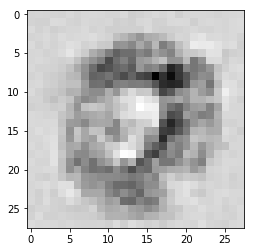

In [24]:
test(0)

[0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


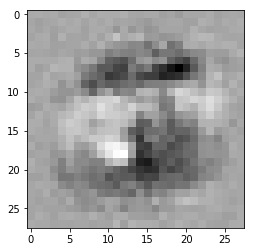

In [25]:
test(1)

[0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


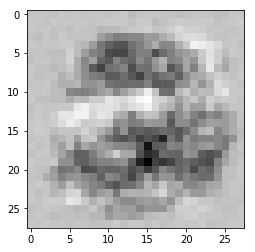

In [26]:
test(2)

[0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01]


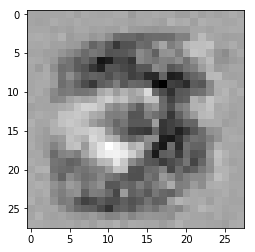

In [27]:
test(3)

[0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01]


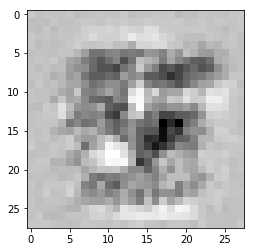

In [28]:
test(4)

[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


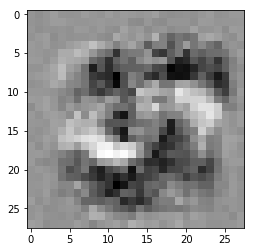

In [29]:
test(5)

[0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01]


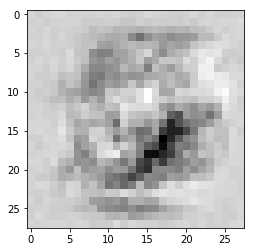

In [30]:
test(6)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01]


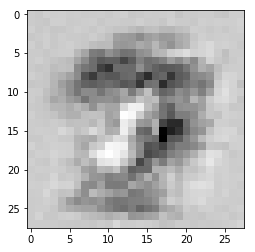

In [31]:
test(7)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01]


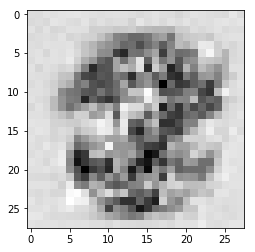

In [32]:
test(8)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99]


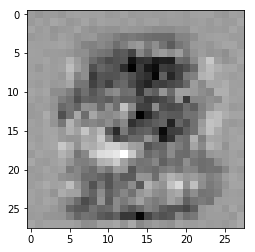

In [33]:
test(9)